# Solving Equilibria with Fixed Axis and Fixed NAE O(rho) Behavior in DESC

This tutorial shows how to find equilibrium solutions in DESC which are constrained to have the same axis and near-axis behavior as a NAE solution from the pyQSC code

# Creating a DESC Equilibrium from a pyQsc Near-Axis Equilibrium

Note that you must have pyQsc installed in order to make use of the `Equilibrium.from_near_axis` method, do so with `pip install qsc`

In [1]:
# must have installed pyQsc with `pip install qsc` in order to use this!
from qsc import Qsc
import numpy as np
import matplotlib.pyplot as plt
from desc.equilibrium import Equilibrium
from desc.objectives import get_fixed_boundary_constraints
from desc.plotting import (
    plot_comparison,
    plot_fsa,
    plot_section,
    plot_surfaces,
    plot_qs_error,
)

DESC version 0.7.2+448.ge7d2c274,using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 20.51 GB available memory


DESC is able to create an equilibrium based off of a `pyQsc` NAE equilibrium object. First, we'll make the NAE equilibrium using `pyQsc`

In [2]:
qsc_eq = Qsc.from_paper("precise QA")

Then, to make the DESC equilibrium, the `Equilibrium` class has a method `Equilibrium.from_near_axis`. This method creates a DESC `Equilibrium` based off of the `pyQsc` equilibrium. It requires as input the desired DESC FourierZernike resolution, as well as the radius at which you want to evaluate the qsc equilibrium at to make the DESC equilibrium's boundary. The equilibrium's initial `R_lmn`, `Z_lmn` Fourier-Zernike coefficients are fit to the `R,Z` evaluated from the `pyQsc` equilibrium, and the initial `L_lmn` are 0 (because the `pyQsc` equilibrium uses Boozer angles, so there is no poloidal stream function)

In [3]:
ntheta = 75
r = 0.35
desc_eq = Equilibrium.from_near_axis(
    qsc_eq,  # the Qsc equilibrium object
    r=r,  # the finite radius (m) at which to evaluate the Qsc surface to use as the DESC boundary
    L=8,  # DESC radial resolution
    M=8,  # DESC poloidal resolution
    N=8,  # DESC toroidal resolution
    ntheta=ntheta,
)
eq_fit = desc_eq.copy()  # copy so we can see the original Qsc surfaces later

Now we solve the equilibrium as normal in DESC

In [4]:
# get the fixed-boundary constraints, which include also fixing the pressure and fixing the current profile (iota=False flag means fix current)
constraints = get_fixed_boundary_constraints(iota=False)
print(constraints)

# solve the equilibrium
desc_eq.solve(
    verbose=3,
    ftol=1e-2,
    objective="force",
    maxiter=100,
    xtol=1e-6,
    constraints=constraints,
)

# Save equilibrium as .h5 file
desc_eq.save("DESC_from_NAE_precise_QA_output.h5")

(<desc.objectives.linear_objectives.FixBoundaryR object at 0x7f771c0ff4c0>, <desc.objectives.linear_objectives.FixBoundaryZ object at 0x7f771c0ffb50>, <desc.objectives.linear_objectives.FixLambdaGauge object at 0x7f771c0ff310>, <desc.objectives.linear_objectives.FixPsi object at 0x7f771c0ff5e0>, <desc.objectives.linear_objectives.FixPressure object at 0x7f771c0ffd90>, <desc.objectives.linear_objectives.FixCurrent object at 0x7f771c0ff280>)
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 386 ms
Timer: Objective build = 3.07 sec
Timer: Linear constraint projection build = 6.29 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 3.48 sec
Timer: Jacobian compilation time = 9.32 sec
Timer: Total compilation time = 12.8 sec
Number of parameters: 856
Number of objectives: 5346
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1581

Now we have a DESC equilibrium solved with the boundary from `pyQsc`. It has zero toroidal current as its profile constraint along with zero pressure since the original Qsc equilibrium had 0 pressure and current.

However, if we plot the surfaces, we see that while the boundary matches, the interior deviates slightly from the NAE, especially near the core. This means we may have lost some of the optimized properties from the QSC equilibrium.

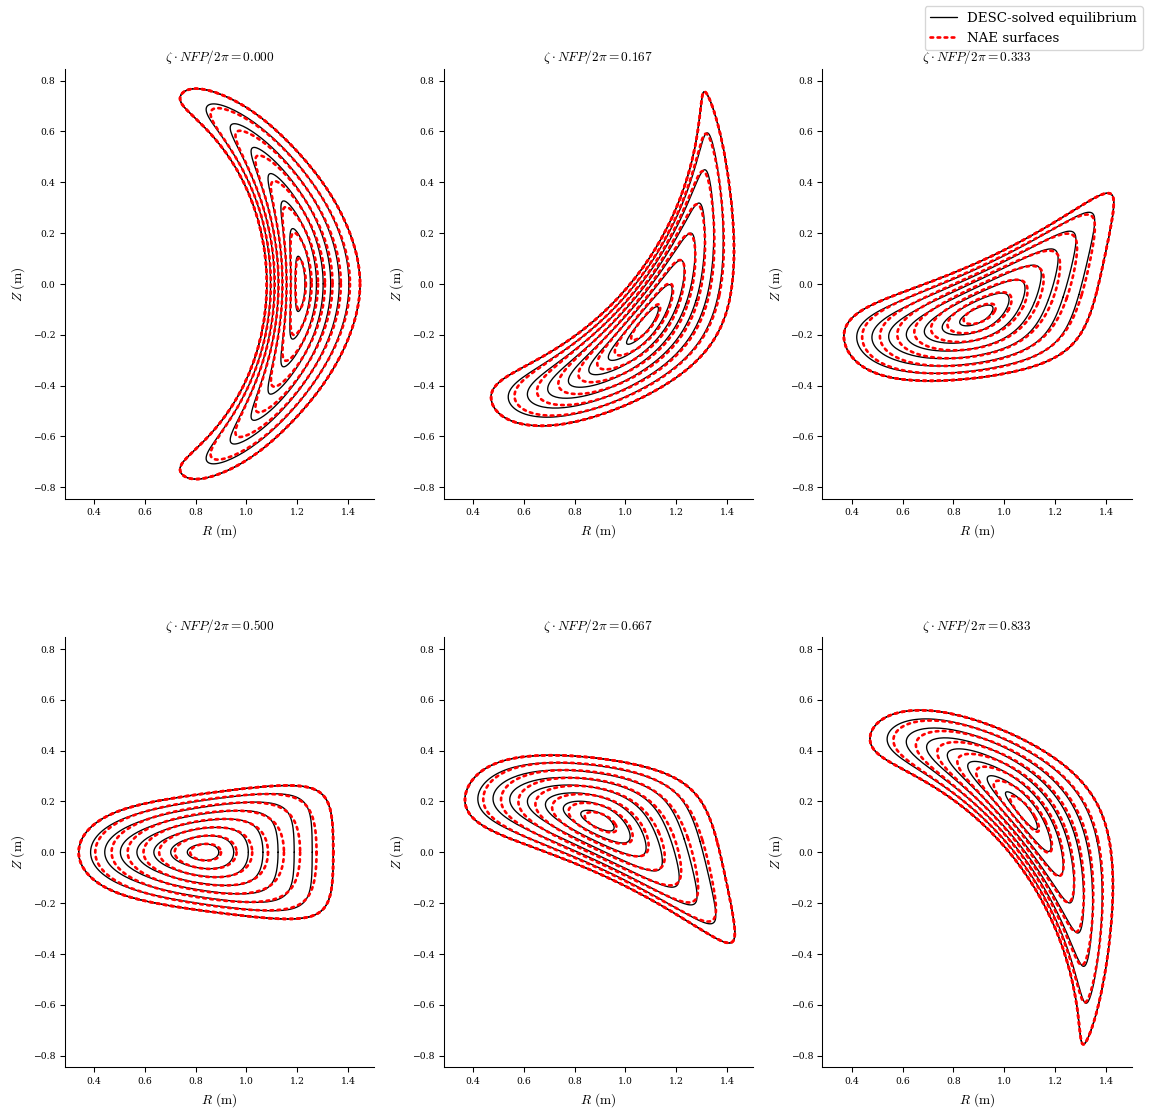

In [5]:
plot_comparison(
    eqs=[desc_eq, eq_fit],
    labels=["DESC-solved equilibrium", "NAE surfaces"],
    figsize=(12, 12),
    theta=0,
    colors=["k", "r"],
    linestyles=["-", ":"],
    lws=[1, 2],
);

Instead of evaluating the NAE at a finite radius, fixing that boundary, and hoping the axis behavior stays the same, we can instead directly fix the axis and the $O(\rho)$ asymptotic behavior.

# Solving Equilibria with Fixed Axis and Fixed NAE $O(\rho)$ Behavior in DESC

In [6]:
# utility functions for getting the NAE constraints
from desc.objectives.utils import get_equilibrium_objective, get_NAE_constraints

eq_NAE = eq_fit.copy()
# this has all the constraints we need, iota=False specifies we want to fix current instead of iota
constraints = get_NAE_constraints(eq_NAE, qsc_eq, iota=False, order=1)

eq_NAE.solve(
    verbose=3,
    ftol=1e-2,
    objective="force",
    maxiter=100,
    xtol=1e-6,
    constraints=constraints,
);

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 236 ms
Timer: Objective build = 557 ms
Timer: Linear constraint projection build = 4.33 sec
Compiling objective function and derivatives
Timer: Objective compilation time = 4.15 sec
Timer: Jacobian compilation time = 9.41 sec
Timer: Total compilation time = 13.5 sec
Number of parameters: 1094
Number of objectives: 5346
Starting optimization
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1717e+01                                    3.62e+04    
       1              3         1.6806e+01      2.49e+01       2.92e-01       3.59e+04    
       2              4         8.5057e-01      1.60e+01       1.78e-01       2.92e+03    
       3              5         3.3639e-01      5.14e-01       2.18e-01       5.29e+02    
       4              6         8.0149e-02      2.56e-01       2.20e-01       2.95e+02    
       5              7     

Again we can plot the surfaces, and we see that in this case, the near axis behavior is preserved, while the outer surfaces differ. This is expected, as the NAE from QSC is only valid asymptotically near the axis. By constraining this behavior we are able to keep all the desireable properties of the NAE where they are valid without overly constraining the problem.

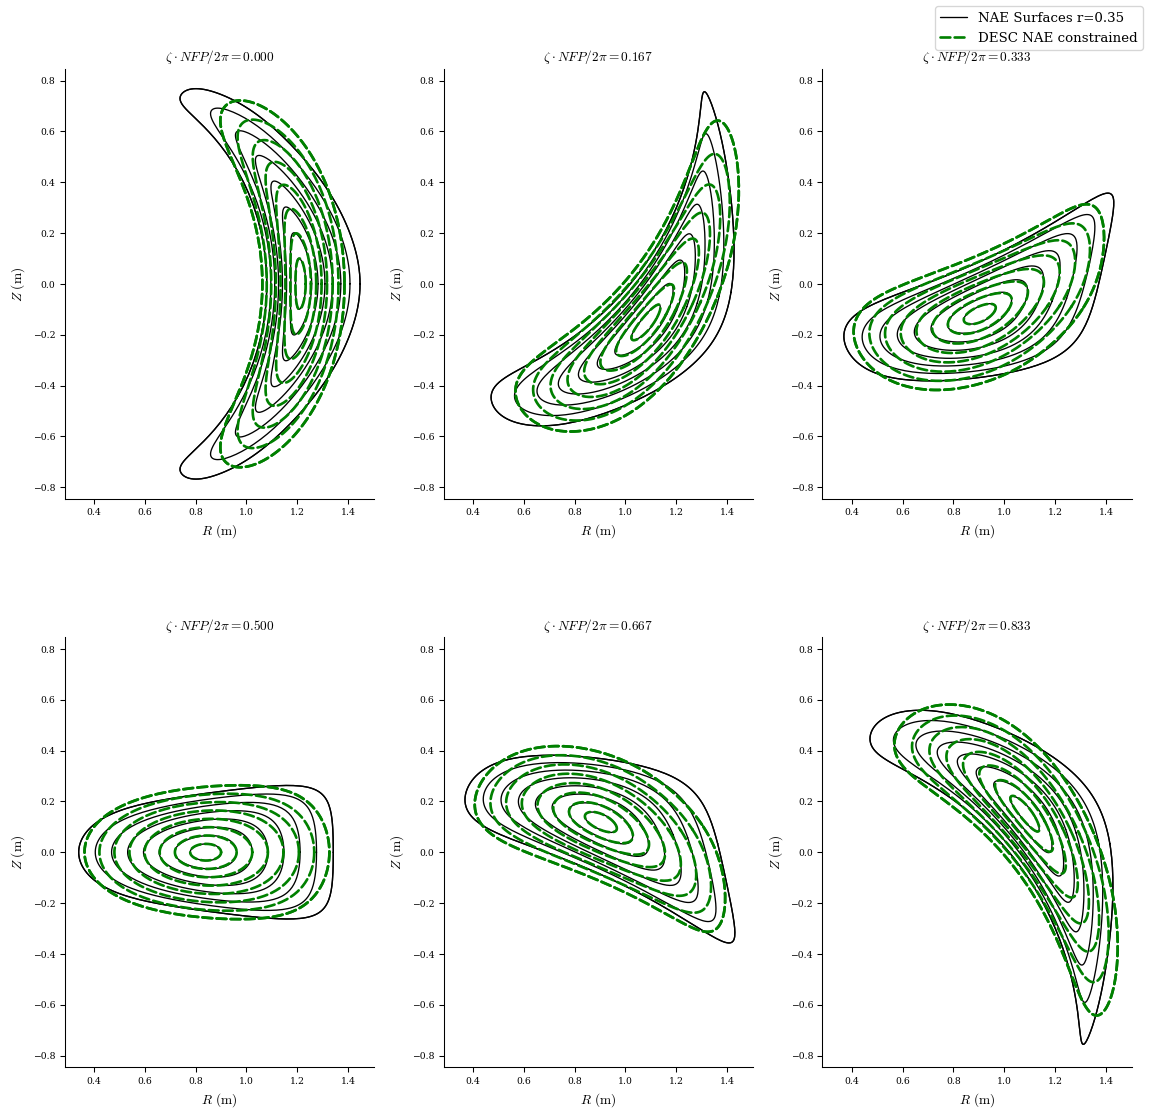

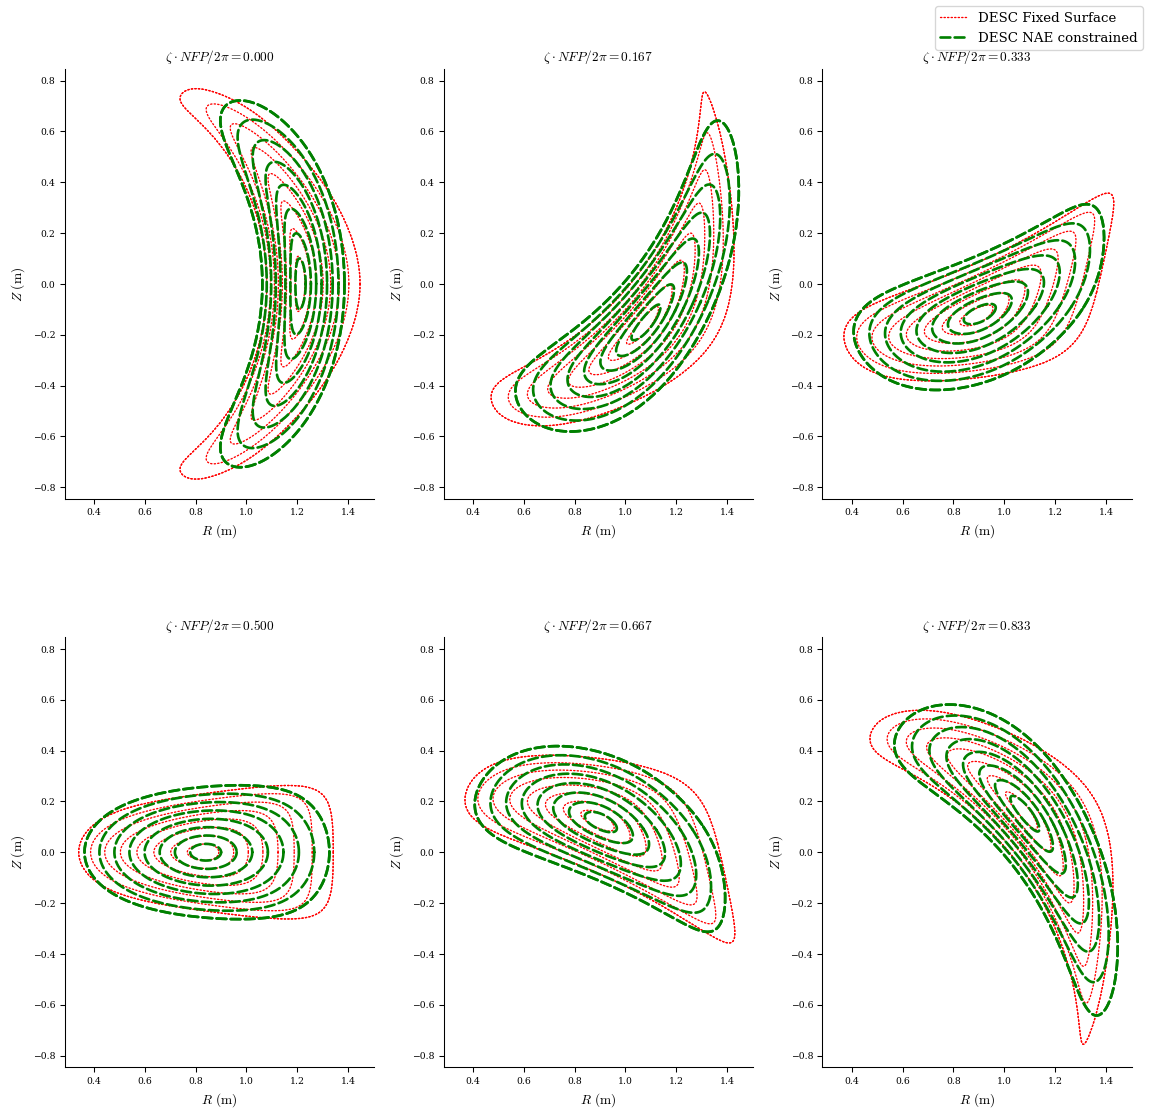

In [7]:
fig, ax = plot_comparison(
    eqs=[eq_fit, eq_NAE],
    labels=[f"NAE Surfaces r={r}", f"DESC NAE constrained"],
    colors=["k", "g"],
    linestyles=["-", "--"],
    figsize=(12, 12),
    theta=0,
    lws=[1, 2],
)
fig, ax = plot_comparison(
    eqs=[desc_eq, eq_NAE],
    labels=[f"DESC Fixed Surface", f"DESC NAE constrained"],
    colors=["r", "g"],
    linestyles=[":", "--"],
    figsize=(12, 12),
    theta=0,
    lws=[1, 2],
);

As a final comparison, we can plot the QS error for the fixed boundary and fixed NAE solves. We see that by fixing the NAE behavior, we are able to preserve the QS from the original QSC equilibrium.

Text(0, 0.5, '$\\sum |B_{mn}|$')

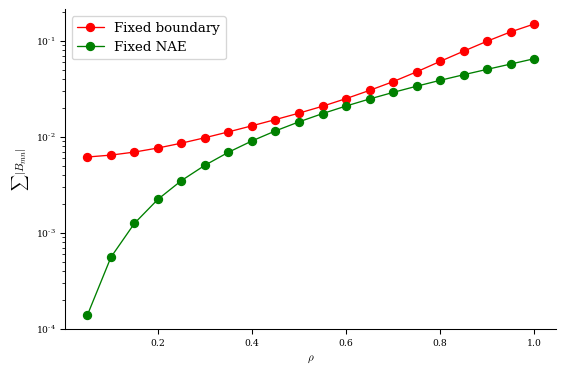

In [8]:
fix, ax = plt.subplots()
plot_qs_error(
    desc_eq,
    fC=False,
    fT=False,
    log=True,
    ax=ax,
    colors=["r"],
    legend=False,
    labels=["Fixed boundary"],
)
plot_qs_error(
    eq_NAE,
    fC=False,
    fT=False,
    log=True,
    ax=ax,
    colors=["g"],
    legend=False,
    labels=["Fixed NAE"],
)
ax.legend()
ax.set_ylabel("$\sum |B_{mn}|$")